## Import Packages

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels
from statsmodels.tsa.stattools import coint

import yfinance as yf

from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Import equity data from yfinance

In [2]:
aapl = yf.Ticker("AAPL")
AAPL = aapl.history(start="2016-06-02", end="2024-06-07")

AAPL

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2016-06-02 00:00:00-04:00,22.336003,22.390927,22.114016,22.363466,160766400,0.0,0.0
2016-06-03 00:00:00-04:00,22.379485,22.489333,22.301674,22.409235,114019600,0.0,0.0
2016-06-06 00:00:00-04:00,22.425255,23.317780,22.324561,22.571720,93170000,0.0,0.0
2016-06-07 00:00:00-04:00,22.713604,22.855493,22.647236,22.663256,89638000,0.0,0.0
2016-06-08 00:00:00-04:00,22.660973,22.784553,22.583164,22.642666,83392400,0.0,0.0
...,...,...,...,...,...,...,...
2024-05-31 00:00:00-04:00,190.798749,191.924969,189.273875,191.606033,75158300,0.0,0.0
2024-06-03 00:00:00-04:00,192.253831,194.336842,191.875114,193.380051,50080500,0.0,0.0
2024-06-04 00:00:00-04:00,193.988012,194.665742,192.383404,193.698990,47471400,0.0,0.0


## Import option data from yfinance

In [9]:
import yfinance as yf
import pandas as pd
from IPython.display import display

# Define the ticker symbol
ticker_symbol = "AAPL"
aapl = yf.Ticker(ticker_symbol)

# Get current stock price
current_price = aapl.history(period="1d")["Close"].iloc[-1]
print(f"\nAAPL Current Price: {current_price:.2f}")

# Get available options expiration dates
expirations = aapl.options

# Retrieve options data for multiple expiration dates
all_options = []
num_strikes = 12  # Number of strikes to keep per expiration (6 ITM + 1 ATM + 5 OTM)

# Limit to first 5 expirations to avoid excessive requests
for expiry in expirations[:5]:  
    option_chain = aapl.option_chain(expiry)
    
    # Get calls and puts data
    calls = option_chain.calls
    puts = option_chain.puts
    
    # Add expiration column for reference
    calls["expiration"] = expiry
    puts["expiration"] = expiry

    # Label calls and puts
    calls["type"] = "call"
    puts["type"] = "put"

    # Combine calls and puts
    options = pd.concat([calls, puts])

    # Sort by strike price
    options = options.sort_values(by="strike").reset_index(drop=True)  # Ensure a clean numeric index

    # Find the closest ATM strike
    atm_index = (options["strike"] - current_price).abs().argsort().iloc[0]  # Get index of the ATM strike

    # Define ITM and OTM boundaries safely
    lower_bound = max(0, atm_index - (num_strikes // 2))  # ITM strikes
    upper_bound = min(len(options) - 1, atm_index + (num_strikes // 2))  # OTM strikes

    # Filter options using `.iloc[]` for numeric indexing
    filtered_options = options.iloc[lower_bound:upper_bound+1]  

    # Append filtered options to final list
    all_options.append(filtered_options)

# Combine into a single DataFrame
options_df = pd.concat(all_options)

# Ensure we have multiple expiration dates
if len(options_df["expiration"].unique()) > 1:
    print("\n✅ Multiple Expirations Included")
else:
    print("\n⚠️ Warning: Only One Expiration Found – Check Filtering!")

# Sort by expiration date and strike price for better readability
options_df = options_df.sort_values(by=["expiration", "strike"]).reset_index(drop=True)

# Select relevant columns for display
columns_to_display = [
    "contractSymbol", "expiration", "strike", "lastPrice", "bid", "ask", "volume",
    "openInterest", "impliedVolatility", "type"
]

# Create a new DataFrame with empty rows separating expiration dates and custom index labels
options_display = []
previous_expiration = None
expiration_count = 2  # Expiration label counter
index_labels = []  # Custom index labels

for _, row in options_df.iterrows():
    if previous_expiration is not None and row["expiration"] != previous_expiration:
        blank_row = pd.Series([""] * len(columns_to_display), index=columns_to_display)  # Truly blank row
        options_display.append(blank_row)  # Add separator row
        index_labels.append(f"Expiration {expiration_count}")  # Label the blank row
        expiration_count += 1  # Increment expiration counter

    options_display.append(row)
    index_labels.append("")  # Empty label for normal rows
    previous_expiration = row["expiration"]

# Convert list back to a DataFrame with custom index labels
options_display_df = pd.DataFrame(options_display)

# Set the custom index
options_display_df.index = index_labels

# Display the cleaned options chain
print("\n✅ AAPL Options Chain (Multiple Expirations, Balanced ATM Strikes):")
display(options_display_df[columns_to_display].head(30))  # Show a reasonable subset



AAPL Current Price: 231.01

✅ Multiple Expirations Included

✅ AAPL Options Chain (Multiple Expirations, Balanced ATM Strikes):


,contractSymbol,expiration,strike,lastPrice,bid,ask,volume,openInterest,impliedVolatility,type
,AAPL250214P00222500,2025-02-14,222.5,0.47,0.47,0.49,120.0,6454,0.317878,put
,AAPL250214C00222500,2025-02-14,222.5,8.5,8.1,8.9,13.0,480,0.296882,call
,AAPL250214P00225000,2025-02-14,225.0,0.82,0.79,0.81,1758.0,10383,0.301277,put
,AAPL250214C00225000,2025-02-14,225.0,6.34,6.2,6.3,616.0,3446,0.211434,call
,AAPL250214C00227500,2025-02-14,227.5,4.45,4.2,4.25,1151.0,3164,0.211922,call
,AAPL250214P00227500,2025-02-14,227.5,1.38,1.34,1.36,1399.0,11090,0.28907,put
,AAPL250214P00230000,2025-02-14,230.0,2.23,2.14,2.19,1011.0,10662,0.276863,put
,AAPL250214C00230000,2025-02-14,230.0,2.93,2.97,3.05,8960.0,13949,0.260994,call
,AAPL250214P00232500,2025-02-14,232.5,3.35,3.45,3.5,307.0,3360,0.277961,put
,AAPL250214C00232500,2025-02-14,232.5,1.69,1.73,1.77,4492.0,12557,0.252449,call


## Monte Carlo - Simulate GMB

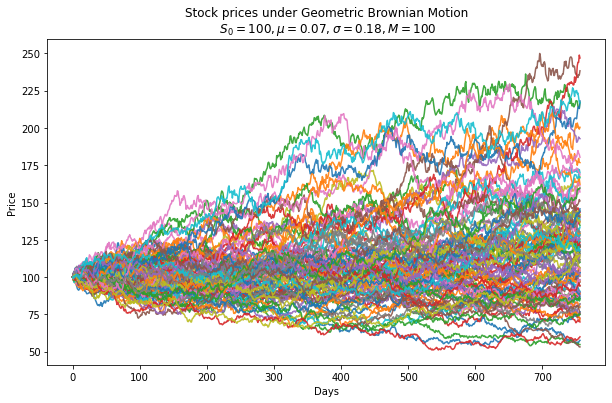

In [21]:
mu = 0.07  # Drift coefficient
T = 3  # Time in years
n = 252 * T  # Number of steps (252 trading days per year)
M = 100  # Number of simulations
S0 = 100  # Initial stock price
sigma = 0.18  # Volatility
dt = T / n  # Step/period length

# Simulation using numpy arrays
St = np.exp(
    (mu - sigma ** 2 / 2) * dt
    + sigma * np.random.normal(0, np.sqrt(dt), size=(M, n)).T
)

# Include array of 1's for the initial price
St = np.vstack([np.ones(M), St])

# Multiply through by S0 and return the cumulative product of elements along a given simulation path (axis=0)
St = S0 * St.cumprod(axis=0)

# Convert to pandas DataFrame
data = pd.DataFrame(St, columns=[f'Stock price sim {i+1}' for i in range(M)])

# Plotting all simulation paths
plt.figure(figsize=(10, 6))

# Plot individual simulation stock prices
for i in range(M):
    plt.plot(data.index, data[f'Stock price sim {i+1}'], label=f'Simulation {i+1}', alpha=0.9)

plt.xlabel('Days')
plt.ylabel('Price')
plt.title(f"Stock prices under Geometric Brownian Motion\n $S_0 = {S0}, \mu = {mu}, \sigma = {sigma}, M = {M}$")
plt.show()


## Create and backtest strategy (using backtesting library) - SEMESTER 1 CONTENT

In [7]:
class SmaCross(Strategy):
    n1 = 10 #sma params
    n2 = 20

    def init(self):
        close = self.data.Close
        self.sma1 = self.I(SMA, close, self.n1)
        self.sma2 = self.I(SMA, close, self.n2)

    def next(self):
        if crossover(self.sma1, self.sma2):
            self.buy()
        elif crossover(self.sma2, self.sma1):
            self.sell()


bt = Backtest(AAPL, SmaCross,
              cash=10000, commission=.002,
              exclusive_orders=True)

output = bt.run()
bt.plot(plot_volume=False)
output

Start                     2016-06-02 00:00...
End                       2024-06-06 00:00...
Duration                   2926 days 00:00:00
Exposure Time [%]                     98.6118
Equity Final [$]                 20731.887628
Equity Peak [$]                  36807.906724
Return [%]                         107.318876
Buy & Hold Return [%]              766.719631
Return (Ann.) [%]                    9.536846
Volatility (Ann.) [%]               30.914522
Sharpe Ratio                         0.308491
Sortino Ratio                        0.503963
Calmar Ratio                         0.196242
Max. Drawdown [%]                  -48.597364
Avg. Drawdown [%]                   -5.036464
Max. Drawdown Duration      861 days 00:00:00
Avg. Drawdown Duration       51 days 00:00:00
# Trades                                   79
Win Rate [%]                        36.708861
Best Trade [%]                      80.599779
Worst Trade [%]                     -13.97792
Avg. Trade [%]                    

## Optimize strategy parameters

In [8]:
stats = bt.optimize(n1=range(5, 30, 5),
                    n2=range(10, 70, 5),
                    maximize='Equity Final [$]',
                    constraint=lambda param: param.n1 < param.n2)
stats

  0%|          | 0/17 [00:00<?, ?it/s]

Start                     2016-06-02 00:00...
End                       2024-06-06 00:00...
Duration                   2926 days 00:00:00
Exposure Time [%]                   98.810114
Equity Final [$]                 62475.225583
Equity Peak [$]                  74139.829287
Return [%]                         524.752256
Buy & Hold Return [%]              766.719631
Return (Ann.) [%]                   25.722835
Volatility (Ann.) [%]               34.988263
Sharpe Ratio                         0.735185
Sortino Ratio                         1.40801
Calmar Ratio                         0.907674
Max. Drawdown [%]                   -28.33928
Avg. Drawdown [%]                   -4.491051
Max. Drawdown Duration      456 days 00:00:00
Avg. Drawdown Duration       31 days 00:00:00
# Trades                                  113
Win Rate [%]                        42.477876
Best Trade [%]                      52.172206
Worst Trade [%]                    -15.693972
Avg. Trade [%]                    